# Deep Neural Network Model for Image Captioning
This notebook demonstrates how to build a deep neural network model for image captioning using a combination of CNN (for feature extraction) and LSTM (for sequence generation).

In [1]:
import numpy as np
import pandas as pd
import os
import string
import glob
from PIL import Image
import os
from pickle import dump, load
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
dataset_text = "C:/Users/KSHITIJ/Desktop/Flickr8k_text"
dataset_images = "C:/Users/KSHITIJ/Desktop/Flicker8k_Dataset"

In [3]:
def load_document(filename):
    file = open(filename , "r")
    text = file.read()
    file.close()
    return text

In [4]:
def load_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

In [5]:
def load_description(filename):
    file = load_document(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [6]:
def clean_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img , caps in captions.items():
        for i , img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            desc = [word for word in desc if(len(word)>1)]
            desc = [word for word in desc if(word.isalpha())]
            
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [7]:
def text_vocabulary(descriptions):
    # building vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [8]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [9]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = load_description(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = clean_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [10]:
show_description = pd.DataFrame(descriptions)
show_description.head().T

,0,1,2,3,4
1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...,girl going into wooden building,little girl climbing into wooden playhouse,little girl climbing the stairs to her playhouse,little girl in pink dress going into wooden cabin
1001773457_577c3a7d70.jpg,black dog and spotted dog are fighting,black dog and tricolored dog playing with each...,black dog and white dog with brown spots are s...,two dogs of different breeds looking at each o...,two dogs on pavement moving toward each other
1002674143_1b742ab4b8.jpg,little girl covered in paint sits in front of ...,little girl is sitting in front of large paint...,small girl in the grass plays with fingerpaint...,there is girl with pigtails sitting in front o...,young girl with pigtails painting outside in t...
1003163366_44323f5815.jpg,man lays on bench while his dog sits by him,man lays on the bench to which white dog is al...,man sleeping on bench outside with white and b...,shirtless man lies on park bench with his dog,man laying on bench holding leash of dog sitti...
1007129816_e794419615.jpg,man in an orange hat starring at something,man wears an orange hat and glasses,man with gauges and glasses is wearing blitz hat,man with glasses is wearing beer can crocheted...,the man with pierced ears is wearing glasses a...
...,...,...,...,...,...
990890291_afc72be141.jpg,man does wheelie on his bicycle on the sidewalk,man is doing wheelie on mountain bike,man on bicycle is on only the back wheel,asian man in orange hat is popping wheelie on ...,man on bicycle riding on only one wheel
99171998_7cc800ceef.jpg,group is sitting around snowy crevasse,group of people sit atop snowy mountain,group of people sit in the snow overlooking mo...,five children getting ready to sled,five people are sitting together in the snow
99679241_adc853a5c0.jpg,grey bird stands majestically on beach while w...,large bird stands in the water on the beach,tall bird is standing on the sand beside the o...,water bird standing at the ocean edge,white crane stands tall as it looks out upon t...
997338199_7343367d7f.jpg,person stands near golden walls,woman behind scrolled wall is writing,woman standing near decorated wall writes,the walls are covered in gold and patterns,woman writing on pad in room with gold decorat...


In [11]:
def extract_features(directory):
    # Load ResNet50 model pre-trained on ImageNet without the top classification layer
    model = ResNet50(include_top=False, pooling='avg')
    features = {}
    
    for img in tqdm(os.listdir(directory)):
        filename = os.path.join(directory, img)
        image = Image.open(filename)
        image = image.resize((224, 224))  # Resize to match ResNet50 input size
        image = img_to_array(image)  # Convert image to array
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        
        # Manually preprocess the image
        image = image / 127.5  # Scale pixel values to [0, 2]
        image = image - 1.0    # Scale pixel values to [-1, 1]
        
        feature = model.predict(image)
        features[img] = feature
    
    return features

In [12]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("new_features.p","wb"))

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [11:48<00:00, 11.43it/s]


In [13]:
features = load(open("new_features.p","rb"))

In [14]:
def load_photos(filename):
    file = load_document(filename)
    photos = file.split("\n")[:-1]
    return photos 

In [15]:
def load_clean_description(filename,photos):
    file = load_document(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words) < 1 :
            continue 

        image , image_caption = words[0] , words[1:]

        if image in photos : 
            if image not in descriptions :
                descriptions[image] = []
            desc = '<start>' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions 

In [16]:
def load_features(photos):
    all_features = load(open("new_features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features

In [17]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_description("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

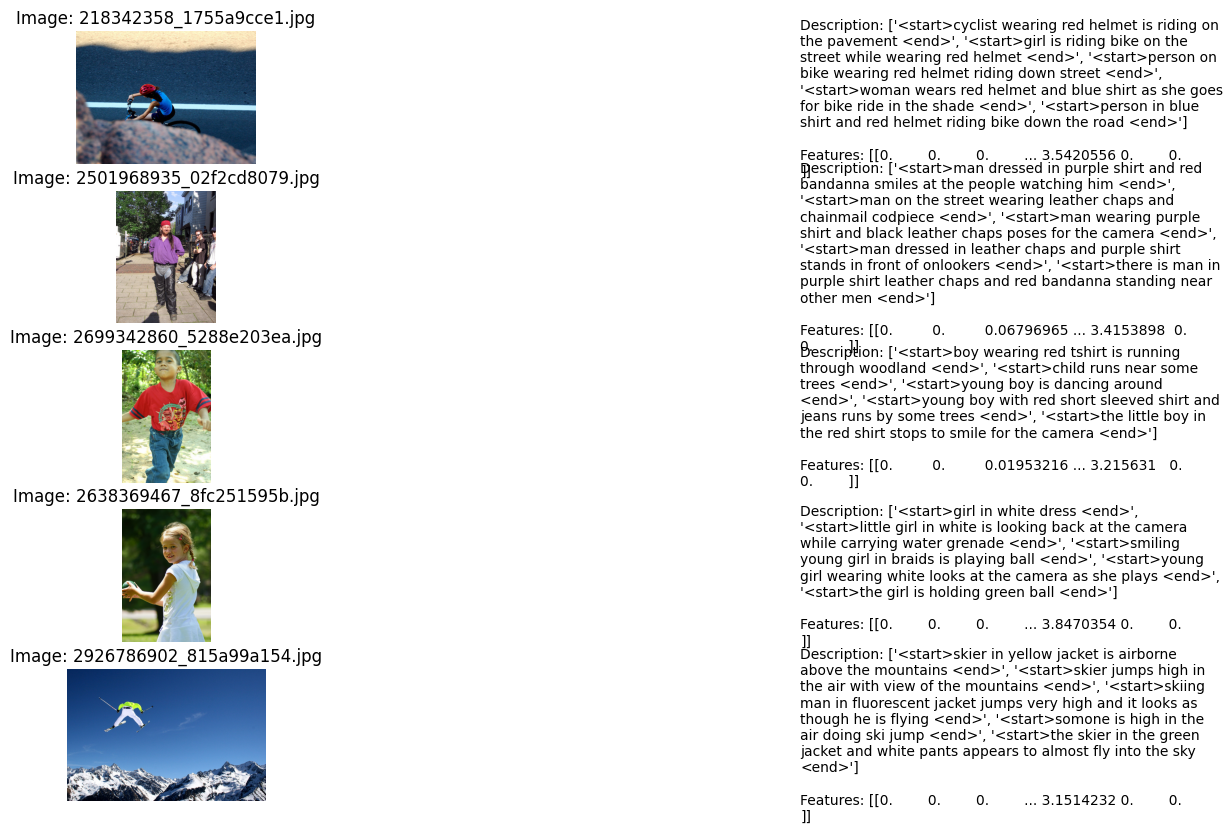

In [18]:
import matplotlib.pyplot as plt

def show_images_with_details(images, descriptions, features, n_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(n_images):
        img_name = images[i+5]
        img_path = os.path.join(images_directory, img_name)
        
        img = Image.open(img_path)
        plt.subplot(n_images, 2, 2*i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {img_name}")
        
        plt.subplot(n_images, 2, 2*i+2)
        desc = descriptions.get(img_name, "No description available")
        feat = features.get(img_name, "No features available")
        plt.text(0.5, 0.5, f"Description: {desc}\n\nFeatures: {feat}", wrap=True, ha='left', va='center')
        plt.axis('off')
    plt.show()

# Load your images, descriptions, and features
# Add your base directory to the image paths
images_directory = "C:/Users/KSHITIJ/Desktop/Flicker8k_Dataset"
train_imgs_paths = [os.path.join(images_directory, img_name) for img_name in train_imgs]

# Display the first 5 images with their descriptions and features
show_images_with_details(train_imgs, train_descriptions, train_features, n_images=5)

In [19]:
train_features['2513260012_03d33305cf.jpg'].shape

(1, 2048)

In [20]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [21]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('new_tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [22]:
import pickle
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Load tokenizer
with open('new_tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)

# View word index mapping
word_index = tokenizer.word_index
print("Word Index Mapping (word -> index):")
for word, index in list(word_index.items())[:20]:  # Displaying the first 20 for brevity
    print(f"{word}: {index}")

# Sample tokenized sequences
sample_descriptions = list(train_descriptions.values())[:5]  # Taking the first 5 descriptions for demonstration
print("\nSample Descriptions:")
for desc_list in sample_descriptions:
    for desc in desc_list:
        print(desc)

print("\nTokenized Sequences:")
for desc_list in sample_descriptions:
    for desc in desc_list:
        sequence = tokenizer.texts_to_sequences([desc])[0]
        print(sequence)


Word Index Mapping (word -> index):
end: 1
start: 2
in: 3
the: 4
on: 5
is: 6
and: 7
dog: 8
with: 9
man: 10
of: 11
two: 12
white: 13
black: 14
boy: 15
are: 16
woman: 17
girl: 18
to: 19
wearing: 20

Sample Descriptions:
<start>child in pink dress is climbing up set of stairs in an entry way <end>
<start>girl going into wooden building <end>
<start>little girl climbing into wooden playhouse <end>
<start>little girl climbing the stairs to her playhouse <end>
<start>little girl in pink dress going into wooden cabin <end>
<start>black dog and spotted dog are fighting <end>
<start>black dog and tricolored dog playing with each other on the road <end>
<start>black dog and white dog with brown spots are staring at each other in the street <end>
<start>two dogs of different breeds looking at each other on the road <end>
<start>two dogs on pavement moving toward each other <end>
<start>little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>
<start>little girl is

In [23]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [24]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.        , 0.        , 0.10725033, ..., 4.0432224 , 0.        ,
       0.        ], dtype=float32)

In [25]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


def data_generator(descriptions, features, tokenizer, max_length, batch_size=32):
    while True:
        X1, X2, y = list(), list(), list()
        n = 0
        for key, desc_list in descriptions.items():
            feature = features[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, feature)
            for i in range(len(in_img)):
                X1.append(in_img[i])
                X2.append(in_seq[i])
                y.append(out_word[i])
                n += 1
                if n == batch_size:
                    yield [np.array(X1), np.array(X2)], np.array(y)
                    X1, X2, y = list(), list(), list()
                    n = 0
        if n > 0:
            yield [np.array(X1), np.array(X2)], np.array(y)



In [26]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((32, 2048), (32, 32), (32, 7577))

In [27]:
# Define the captioning model
def define_model(vocab_size, max_length):
    # CNN feature extraction model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(256, activation='relu')(fe3)
    
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(256)(se4)
    
    # Merging both models
    decoder1 = add([fe4, se5])
    decoder2 = Dense(512, activation='relu')(decoder1)
    decoder3 = Dropout(0.5)(decoder2)
    decoder4 = Dense(256, activation='relu')(decoder3)
    outputs = Dense(vocab_size, activation='softmax')(decoder4)
    
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # Summarize model
    print(model.summary())
    plot_model(model, to_file='deep_model.png', show_shapes=True)
    
    return model

In [31]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
batch_size = 32 

epochs = 10
steps = len(train_descriptions) // 32  # Adjust steps per epoch

os.makedirs("new_models", exist_ok=True)

early_stopping = EarlyStopping(
    monitor='loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='loss',  # Metric to monitor
    factor=0.2,          # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6          # Lower bound on the learning rate
)

model = define_model(vocab_size, max_length)

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, 
             callbacks=[early_stopping, reduce_lr])
    model.save(f"new_models/model_{i}.h5")


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 256)      1939712     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 2048)         0           input_7[0][0]      

In [40]:
import os
import numpy as np
import pickle
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Directory containing the images
images_directory = "images"

# Load the saved model
saved_model_path = "new_models/model_9.h5"  # Adjust based on your saved model
saved_model = load_model(saved_model_path)

# Load tokenizer from file
with open('new_tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)

# Load ResNet50 model for feature extraction
base_model = ResNet50(include_top=False, pooling="avg")
feature_extractor_model = Model(inputs=base_model.input, outputs=base_model.output)  # Remove the top classification layer

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to preprocess image and extract features
def preprocess_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))  # Resize to match ResNet50 input size
    img = img_to_array(img)
    img = img / 127.5  # Scale pixel values to [0, 2]
    img = img - 1.0    # Scale pixel values to [-1, 1]
    img = np.expand_dims(img,axis=0)
    #img = preprocess_input(img)
    features = model.predict(img, verbose=0)
    return features

# Function to generate captions for an image
def generate_caption_for_image(image_path, feature_extractor_model, max_length, tokenizer, saved_model):
    # Preprocess the image and extract features
    image_features = preprocess_image(image_path, feature_extractor_model)
    
    # Generate caption
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = saved_model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Example usage to generate captions for each image
max_length = 32  # Adjust based on your model's maximum caption length
captions = {}

image_path = os.path.join(images_directory, filename)
caption = generate_caption_for_image("images/1.jpg", feature_extractor_model, max_length, tokenizer, saved_model)
print(caption)



start man is blue shirt and shorts is into the the street end


In [37]:
saved_model_path = "new_models/model_9.h5"  # Adjust based on your saved model
saved_model = load_model(saved_model_path)

base_model = ResNet50(include_top=False, pooling="avg")
feature_extractor_model = Model(inputs=base_model.input, outputs=base_model.output)  # Remove the top classification layer


def preprocess_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))  # Resize to match ResNet50 input size
    img = img_to_array(img)
    img = img / 127.5  # Scale pixel values to [0, 2]
    img = img - 1.0    # Scale pixel values to [-1, 1]
    img = np.expand_dims(img,axis=0)
    #img = preprocess_input(img)
    features = model.predict(img, verbose=0)
    return features

# Directory containing the images
images_directory = "images"
l = preprocess_image("images/1.jpg",feature_extractor_model)
print(l)


[[0.         0.         0.01600813 ... 2.5530925  0.         0.        ]]
